# **Football Player Segmentation**

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## I. Pre-processing

### I.1. Dataset class

In [2]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
# from torchvision import transforms
from pycocotools import mask as coco_mask
import torch.nn.functional as F_nn


class FootballSegmentDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None, frame_step=1):
        self.root_dir = root_dir
        self.transforms = transforms
        self.frame_step = frame_step

        with open(annotation_file, 'r') as f:
            self.coco = json.load(f)

        self.image_id_to_info = {img['id']: img for img in self.coco['images']}
        self.id_to_annotations = {}

        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.id_to_annotations:
                self.id_to_annotations[img_id] = []
            self.id_to_annotations[img_id].append(ann)

        # Filter image IDs with step
        full_ids = list(self.id_to_annotations.keys())
        self.image_ids = full_ids[::self.frame_step]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.image_id_to_info[img_id]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        height, width = img_info['height'], img_info['width']
        anns = self.id_to_annotations[img_id]
        masks = []
        for ann in anns:
            segmentation = ann['segmentation']
            rles = coco_mask.frPyObjects(segmentation, height, width)
            rle = coco_mask.merge(rles)
            m = coco_mask.decode(rle)
            masks.append(m)

        if masks:
            mask = np.any(np.stack(masks, axis=0), axis=0).astype(np.uint8)
        else:
            mask = np.zeros((height, width), dtype=np.uint8)

        mask = Image.fromarray(mask)

        if self.transforms:
            img, mask = self.transforms(img, mask)
        else:
            img = T.ToTensor()(img)
            mask = torch.from_numpy(np.array(mask)).long()

        return img, mask


### I.2. Transform

In [3]:
import random
from torchvision.transforms import functional as F

# Augmentations for TRAINING only
class JointTrainTransform:
    def __init__(self, resize=(256, 256), hflip_prob=0.5, vflip_prob=0.5):
        self.resize = resize
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    def __call__(self, img, mask):
        img = F.resize(img, self.resize)
        mask = F.resize(mask, self.resize, interpolation=Image.NEAREST)

        if random.random() < self.hflip_prob:
            img = F.hflip(img)
            mask = F.hflip(mask)

        if random.random() < self.vflip_prob:
            img = F.vflip(img)
            mask = F.vflip(mask)

        img = self.color_jitter(img)
        img = F.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()
        img = self.normalize(img)
        return img, mask

# Minimal transform for VAL & TEST
class JointEvalTransform:
    def __init__(self, resize=(256, 256)):
        self.resize = resize
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    def __call__(self, img, mask):
        img = F.resize(img, self.resize)
        mask = F.resize(mask, self.resize, interpolation=Image.NEAREST)

        img = F.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()
        img = self.normalize(img)
        return img, mask

### I.3. Dataset

In [4]:
import torch.utils.data as data
from torchvision import utils
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset

resize=(256, 256)
frame_step=5

# Dataset
train_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
    transforms=JointTrainTransform(resize=resize),
    frame_step=frame_step
)

val_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
    transforms=JointEvalTransform(resize=resize),
    frame_step=frame_step
)

test_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
    transforms=JointEvalTransform(resize=resize),
    frame_step=frame_step
)

# Splitting
#-- Dataset splitting: Train - Val - Test: 70-15-15
#-- Train: 70%
#-- Val: 15% for comparison between models
#-- Test: 15% for final estimation of the model performance

total_size = len(train_dataset)
indices = list(range(total_size))
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

trainset = Subset(train_dataset, train_idx)
valset = Subset(val_dataset, val_idx)
testset = Subset(test_dataset, test_idx)

## II. Supported functions

### Loss function

In [5]:
import torch.nn as nn

class BCEJaccardWithLogitsLoss(nn.Module):
    def __init__(self, jaccard_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight
        self.smooth = smooth

    def forward(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        if self.jaccard_weight:
            targets = (targets == 1.0).float()
            targets = targets.view(-1)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.view(-1)

            intersection = (targets * outputs).sum()
            union = outputs.sum() + targets.sum() - intersection

            loss -= self.jaccard_weight * torch.log((intersection + self.smooth ) / (union + self.smooth )) # try with 1-dice
        return loss

class BCEDiceWithLogitsLoss(nn.Module):
    def __init__(self, dice_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.smooth = smooth
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = F_nn.sigmoid(outputs)
        outputs = outputs.view(-1)

        intersection = (outputs * targets).sum()
        dice = 2.0 * (intersection + self.smooth)  / (targets.sum() + outputs.sum() + self.smooth)
        
        loss -= self.dice_weight * torch.log(dice) # try with 1- dice

        return loss
    
class FocalWithLogitsLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha = alpha
        self.gamma = gamma
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = torch.sigmoid(outputs)
        outputs = outputs.view(-1)
        outputs = torch.where(targets == 1, outputs, 1 - outputs)

        focal = self.alpha * (1 - outputs) ** (self.gamma)
        loss *= focal.mean()

        return loss

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F_nn.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [6]:
import os
import json
import gc
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

# ========== 1. Define training and validation loop ==========
def train_and_validate(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train()
        running_train_loss = 0.0
        for images, masks in trainloader:
            gc.collect()
            torch.cuda.empty_cache()
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).unsqueeze(1).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(trainloader)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, masks in testloader:
                gc.collect()
                torch.cuda.empty_cache()
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True).unsqueeze(1).float()
                outputs = model(images)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(testloader)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return model, train_losses, val_losses

# ========== 2. Evaluation ==========
def evaluate_segmentation_model(model, dataloader, device, threshold=0.5):
    model.eval()
    iou_scores, dice_scores, precisions, recalls, f1s, pixel_accuracies, mae_scores = [], [], [], [], [], [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).float()
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()
            preds_flat = preds.view(-1).cpu().numpy()
            masks_flat = masks.view(-1).cpu().numpy()

            intersection = np.logical_and(preds_flat, masks_flat).sum()
            union = np.logical_or(preds_flat, masks_flat).sum()
            iou = intersection / union if union != 0 else 0
            dice = (2 * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-8)
            pixel_acc = (preds_flat == masks_flat).mean()
            mae = np.abs(preds_flat - masks_flat).mean()

            iou_scores.append(iou)
            dice_scores.append(dice)
            pixel_accuracies.append(pixel_acc)
            mae_scores.append(mae)
            precisions.append(precision_score(masks_flat, preds_flat, zero_division=0))
            recalls.append(recall_score(masks_flat, preds_flat, zero_division=0))
            f1s.append(f1_score(masks_flat, preds_flat, zero_division=0))

    metrics = {
        "IoU": float(np.mean(iou_scores)),
        "Dice": float(np.mean(dice_scores)),
        "Precision": float(np.mean(precisions)),
        "Recall": float(np.mean(recalls)),
        "F1 Score": float(np.mean(f1s)),
        "Pixel Accuracy": float(np.mean(pixel_accuracies)),
        "MAE": float(np.mean(mae_scores))
    }
    return metrics

# ========== 3. Run experiment and save results ==========
def run_experiment(model_class, model_name, learning_rate, batch_size, num_epochs, loss_function,
                   trainset, valset, device="cuda", output_dir="outputs/UNet"):
    os.makedirs(output_dir, exist_ok=True)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=1)
    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model, train_losses, val_losses = train_and_validate(
        model=model,
        trainloader=trainloader,
        testloader=valloader,
        criterion=loss_function,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device
    )

    metrics = evaluate_segmentation_model(model, valloader, device)
    model_save_path = os.path.join(output_dir, f"{model_name}_model.pt")
    torch.save(model.state_dict(), model_save_path)

    result = {
        "model_name": model_name,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "loss_function": loss_function.__class__.__name__,
        "train_losses": train_losses,
        "val_losses": val_losses,
        **metrics
    }

    return result, model_save_path

# ========== 4. Final model ==========
def train_final_model(model_class, model_name, learning_rate, batch_size, num_epochs, loss_function,
                      trainval_set, test_set, device="cuda", output_dir="outputs/final_model"):

    # Create directories
    os.makedirs(output_dir, exist_ok=True)

    # DataLoaders
    trainloader = DataLoader(trainval_set, batch_size=batch_size, shuffle=True, num_workers=12)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)

    # Initialize model
    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train
    model, train_losses, val_losses = train_and_validate(
        model=model,
        trainloader=trainloader,
        testloader=testloader,  # testloader used here just for validation loss logging
        criterion=loss_function,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device
    )

    # Final evaluation
    final_metrics = evaluate_segmentation_model(model, testloader, device)

    # Save model
    model_path = os.path.join(output_dir, f"{model_name}_final.pt")
    torch.save(model.state_dict(), model_path)

    # Save results
    results = {
        "model_name": model_name,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "loss_function": loss_function.__class__.__name__,
        "train_losses": train_losses,
        "val_losses": val_losses,
        **final_metrics
    }

    json_path = os.path.join(output_dir, f"{model_name}_final_results.json")
    with open(json_path, "w") as f:
        json.dump(results, f, indent=4)

    print(f"\nFinal model saved to: {model_path}")
    print(f"Final metrics: {final_metrics}")
    return model, results


In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# Function to load JSON summary and return dataframe
def load_experiment_summary(path, drop_losses=True):
    with open(path, "r") as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    if drop_losses:
        df = df.drop(columns=["train_losses", "val_losses", "model_path"])
    return df

# Function to plot all loss curves in a grid layout (3 per row)
def plot_loss_curves_from_json_grid(path, columns=3):
    with open(path, "r") as f:
        experiments = json.load(f)

    total = len(experiments)
    rows = math.ceil(total / columns)

    fig, axes = plt.subplots(rows, columns, figsize=(6 * columns, 4 * rows))

    for i, exp in enumerate(experiments):
        row, col = divmod(i, columns)
        ax = axes[row][col] if rows > 1 else axes[col]

        name = exp["model_name"]
        train_losses = exp["train_losses"]
        val_losses = exp["val_losses"]

        ax.plot(train_losses, label="Train")
        ax.plot(val_losses, label="Val")
        ax.set_title(name)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

    # Hide any empty subplots
    for j in range(total, rows * columns):
        row, col = divmod(j, columns)
        ax = axes[row][col] if rows > 1 else axes[col]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## III. Model and training

### ResUNet++ (Custom architecture)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F_nn

class ConvBlock(nn.Module): # do not modify shape asides number of channels
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.same_channels = (in_channels == out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if not self.same_channels else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.res_conv(identity)
        out += identity
        return self.relu(out)

class ResUNetPlusPlus(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        n1 = 64
        filters = [n1, n1*2, n1*4, n1*8, n1*16]

        # Encoder
        self.conv0_0 = ConvBlock(in_ch, filters[0]) 
        self.conv1_0 = ConvBlock(filters[0], filters[1])
        self.conv2_0 = ConvBlock(filters[1], filters[2])
        self.conv3_0 = ConvBlock(filters[2], filters[3])
        self.conv4_0 = ConvBlock(filters[3], filters[4])

        # Decoder (nested)
        self.conv0_1 = ConvBlock(filters[0]+filters[1], filters[0]) # 64+128 -> 64
        self.conv1_1 = ConvBlock(filters[1]+filters[2], filters[1]) # 128+256 -> 128
        self.conv2_1 = ConvBlock(filters[2]+filters[3], filters[2]) # 256+512 -> 256
        self.conv3_1 = ConvBlock(filters[3]+filters[4], filters[3]) # 512+1024 -> 512

        self.conv0_2 = ConvBlock(filters[0]*2 + filters[1], filters[0]) # 64*2+128=256 -> 64
        self.conv1_2 = ConvBlock(filters[1]*2 + filters[2], filters[1]) # 512 -> 128
        self.conv2_2 = ConvBlock(filters[2]*2 + filters[3], filters[2]) # 1024 -> 256

        self.conv0_3 = ConvBlock(filters[0]*3 + filters[1], filters[0]) # 64*3+128 ->64
        self.conv1_3 = ConvBlock(filters[1]*3 + filters[2], filters[1]) # 128*3+256 -> 128

        self.conv0_4 = ConvBlock(filters[0]*4 + filters[1], filters[0]) # 64*4+128 -> 64

        # Final convolution layers
        if self.deep_supervision:
            self.final = nn.ModuleList([nn.Conv2d(filters[0], out_ch, kernel_size=1) for _ in range(4)])
        else:
            self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.up = lambda x, scale_factor=2: F_nn.interpolate(x, scale_factor=scale_factor, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x0_0 = self.conv0_0(x) # c = 64, h = 256
        x1_0 = self.conv1_0(self.pool(x0_0)) # c=128, h=128
        x2_0 = self.conv2_0(self.pool(x1_0)) # c=256, h=64
        x3_0 = self.conv3_0(self.pool(x2_0)) # c=512, h=32
        x4_0 = self.conv4_0(self.pool(x3_0)) # c=1024, h=16

        # Decoder
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        # x0_1 c=64 h=
        # x0_0 c=64, h=256, upx1_0 c=128, h=128 -> concat c=64+128, h=128
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            outputs = [self.final[i](x) for i, x in enumerate([x0_1, x0_2, x0_3, x0_4])]
            return outputs
        else:
            return self.final(x0_4)

In [9]:
from torch.utils.data import ConcatDataset

# Merge training and validation sets
trainval_set = ConcatDataset([trainset, valset])

# Final training
final_model, final_results = train_final_model(
    model_class=lambda: ResUNetPlusPlus(in_ch=3, out_ch=1, deep_supervision=False),
    model_name="UNet_Final",
    learning_rate=1e-4,
    batch_size=4,
    num_epochs=40,
    loss_function=nn.BCEWithLogitsLoss(),
    trainval_set=trainval_set,
    test_set=testset,
    device=device
)


Epoch 1/40
Train Loss: 0.2000 | Val Loss: 0.1365

Epoch 2/40
Train Loss: 0.0346 | Val Loss: 0.0284

Epoch 3/40
Train Loss: 0.0210 | Val Loss: 0.0183

Epoch 4/40
Train Loss: 0.0177 | Val Loss: 0.0141

Epoch 5/40
Train Loss: 0.0143 | Val Loss: 0.0144

Epoch 6/40
Train Loss: 0.0123 | Val Loss: 0.0112

Epoch 7/40
Train Loss: 0.0115 | Val Loss: 0.0107

Epoch 8/40
Train Loss: 0.0103 | Val Loss: 0.0093

Epoch 9/40
Train Loss: 0.0101 | Val Loss: 0.0094

Epoch 10/40
Train Loss: 0.0098 | Val Loss: 0.0090

Epoch 11/40
Train Loss: 0.0093 | Val Loss: 0.0086

Epoch 12/40
Train Loss: 0.0087 | Val Loss: 0.0087

Epoch 13/40
Train Loss: 0.0088 | Val Loss: 0.0082

Epoch 14/40
Train Loss: 0.0086 | Val Loss: 0.0083

Epoch 15/40
Train Loss: 0.0091 | Val Loss: 0.0090

Epoch 16/40
Train Loss: 0.0080 | Val Loss: 0.0084

Epoch 17/40
Train Loss: 0.0078 | Val Loss: 0.0076

Epoch 18/40
Train Loss: 0.0077 | Val Loss: 0.0073

Epoch 19/40
Train Loss: 0.0076 | Val Loss: 0.0075

Epoch 20/40
Train Loss: 0.0076 | Val Lo

## Results

In [32]:
import pandas as pd

with open("outputs/final_model/UNet_Final_final_results.json", "r") as f:
    data = json.load(f)

df_summary = pd.DataFrame(data)
df_summary = df_summary.drop(columns=["train_losses", "val_losses"]).drop_duplicates()
df_summary

,model_name,learning_rate,batch_size,num_epochs,loss_function,IoU,Dice,Precision,Recall,F1 Score,Pixel Accuracy,MAE
0,UNet_Final,0.0001,4,40,BCEWithLogitsLoss,0.861662,0.925587,0.901237,0.951506,0.925587,0.997292,0.002708


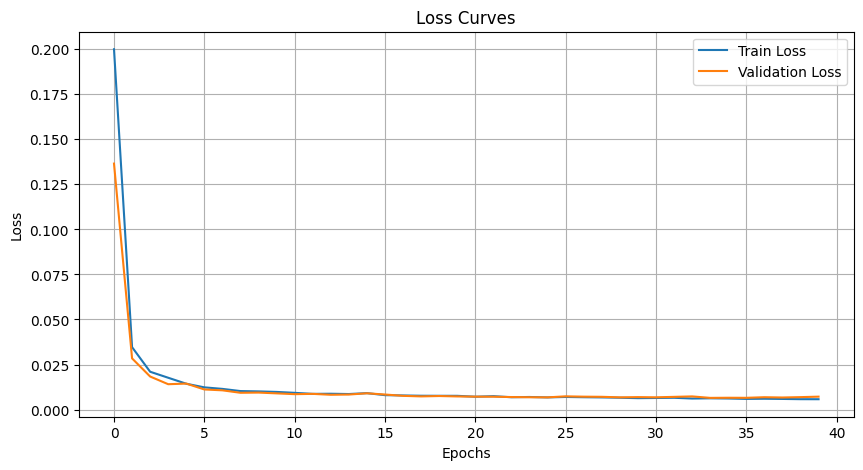

In [33]:
with open("outputs/final_model/UNet_Final_final_results.json", "r") as f:
    data = json.load(f)

fig = plt.figure(figsize=(10, 5))
plt.plot(data["train_losses"], label="Train Loss")
plt.plot(data["val_losses"], label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("outputs/final_model/UNet_Final_loss_curves.png")
plt.show()

## Mask generation

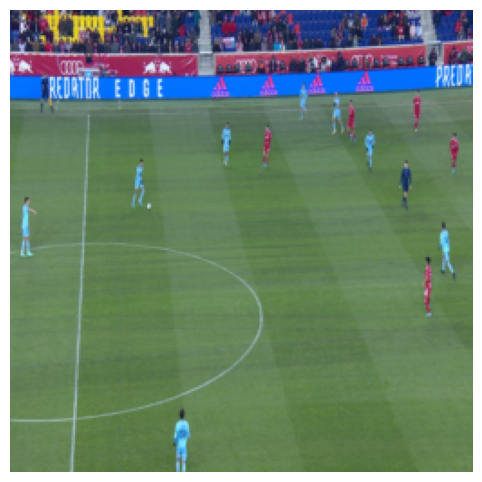

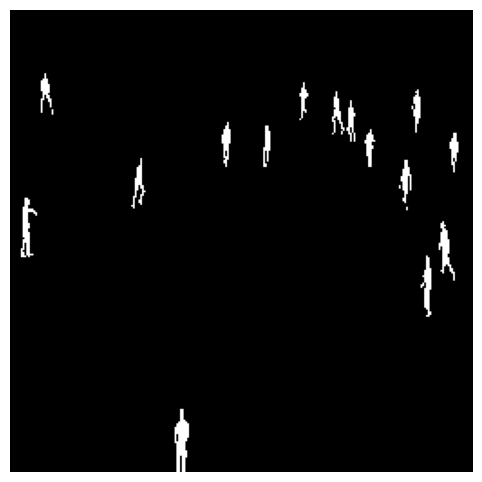

In [52]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms import functional as F

def show_images(imgs, title="Images"):
    # imgs: batch tensor of shape (B, C, H, W)
    img_grid = make_grid(imgs, nrow=4, normalize=True)
    img_pil = F.to_pil_image(img_grid)
    plt.figure(figsize=(12, 6))
    plt.imshow(img_pil)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_masks(masks, title="Masks"):
    # masks: batch tensor of shape (B, 1, H, W) or (B, H, W)
    # Convert to grid and use grayscale colormap
    if masks.dim() == 4:
        masks = masks.squeeze(1)  # (B, H, W)
    mask_grid = make_grid(masks.unsqueeze(1).float(), nrow=4, normalize=True)
    mask_pil = F.to_pil_image(mask_grid)
    plt.figure(figsize=(12, 6))
    plt.imshow(mask_pil, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load 1 batch
testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
images, masks = next(iter(testloader))

# Visualize
show_images(images, title="")
show_masks(masks, title="")

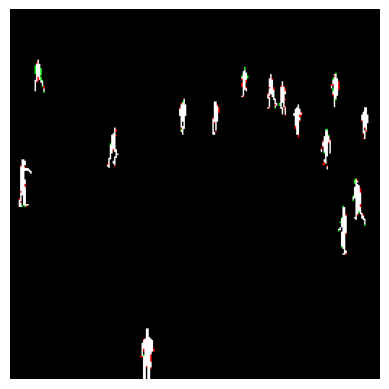

In [73]:
model = ResUNetPlusPlus(in_ch=3, out_ch=1, deep_supervision=False)

model.load_state_dict(torch.load("outputs/final_model/UNet_Final_final.pt", map_location=device))

model = model.to(device)

threshold=0.5

model.eval()
model.to(device)

images = images.to(device)
masks = masks.to(device).float().unsqueeze(1)  # Ensure shape is (B, 1, H, W)

with torch.no_grad():
    logits = model(images)
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

# Select the first image, predicted mask, and ground truth
pred = preds[0].cpu().squeeze().numpy()
true = masks[0].cpu().squeeze().numpy()

# Initialize RGB image
h, w = pred.shape
result = np.zeros((h, w, 3), dtype=np.uint8)

# True Positive (1 & 1) → white
result[(true == 1) & (pred == 1)] = [255, 255, 255]

# False Negative (true=1, pred=0) → green
result[(true == 1) & (pred == 0)] = [0, 255, 0]

# False Positive (true=0, pred=1) → red
result[(true == 0) & (pred == 1)] = [255, 0, 0]

# True Negative (0 & 0) → black (already zero)

# Show the error map
plt.imshow(result)
plt.axis('off')
# plt.title("Prediction Error Visualization")
plt.show()